# Introduction

The preprocessing of the California Fire Perimeters dataset involved several crucial steps, from data acquisition and format conversion to spatial filtering and visualization, providing valuable insights into wildfire patterns, particularly within the Los Angeles city boundary.

**Data Acquisition and Preparation:**

* The **California Fire Perimeters dataset**, sourced from CAL FIRE, was successfully downloaded as a GeoJSON file. This dataset covers fires across California back to 1878 and is updated annually.
* The GeoJSON data was then converted to a CSV format and subsequently loaded into a **GeoDataFrame** for efficient spatial operations. The initial statewide dataset contains 22,810 records with 22 columns, encompassing fire details from 1878 to 2025.

**Spatial Filtering and Clipping for Los Angeles:**

* The **Los Angeles city boundary** was downloaded and used as a spatial reference.
* Two distinct spatial operations were performed on the California fire data relative to the Los Angeles city boundary:
    * **Filtering by Intersection:** This operation identified 458 fire perimeters that **intersected** with (i.e., touched or overlapped) the Los Angeles city boundary. The resulting "unclipped" fires show the full extent of these perimeters, some of which extend significantly outside the city limits.
    * **Clipping:** This operation precisely cut the fire perimeters to only include the portions that fall strictly **within** the Los Angeles city boundary. The "clipped" fires visually represent only the burnt areas inside the city, providing a more accurate view of the direct impact within the urban area.

**Insights from Visualizations:**

* **Original vs. Clipped Comparison:** Visualizations clearly demonstrate the difference between the "unclipped" fires (showing their full extent even if partially outside the boundary) and the "clipped" fires (showing only the portions within the boundary). This highlights the importance of choosing the appropriate spatial operation (intersection versus clipping) based on the analytical objective.
* **Grouping by Year:** Fires were color-coded by their 'YEAR\_' of occurrence, allowing for a chronological visual analysis of fire activity around and within Los Angeles. The range of years for fires intersecting LA spans from 1878 to 2025, with unique values observed for each year.
* **Grouping by Agency:** Visualizing fires by the responsible 'AGENCY' reveals which entities manage or respond to fires in and around the Los Angeles area, such as CCO (Contract County), CDF (CAL FIRE), LRA (Local Responsibility Area), NPS (National Park Service), and USF (US Forest Service).
* **Grouping by Cause:** The 'CAUSE' attribute categorizes fires (e.g., lightning, equipment use, smoking), providing insights into common ignition sources in the region. The scale of causes ranges from 2 to 14, suggesting various contributing factors.

**Data Characteristics and Limitations:**

* The dataset provides detailed attributes for each fire, including 'OBJECTID', 'FIRE\_NAME', 'GIS\_ACRES', and 'ALARM\_DATE'.
* The official data description from CAL FIRE clarifies the criteria for data collection (e.g., fires $\ge$ 10 acres in timber, $\ge$ 50 acres in brush, or $\ge$ 300 acres in grass, and/or $\ge$ 3 damaged/destroyed residential or commercial structures, and/or caused $\ge$ 1 fatality).
* It also highlights **discrepancies with the CAL FIRE Redbook Large Damaging Fires**, enumerating specific historical fires missing from the digital perimeter data.

# Import libraries

In [79]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

# Read the `CSV` and make plots

In [80]:
def read_geo_df(path: str):
    df = pd.read_csv(path)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs("EPSG:4326", inplace=True)
    return df, gdf

def print_df_info(df, name):
    print(f"--- Info for {name} ---")
    print("Dimensions:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Unique YEAR_ values:", df['YEAR_'].unique())
    print()

In [81]:
ca_fire_0_df, ca_fire_0_gdf = read_geo_df("california_fire_perimeters_0.csv")
print_df_info(ca_fire_0_gdf, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (22810, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2024. 2023. 2022. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014.
 2013. 2012. 2011. 2010. 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2002.
 2001. 2000. 1999. 1998. 1997. 1996. 1995. 1994. 1993. 1992. 1991. 1990.
 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979. 1978.
 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967. 1966.
 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955. 1954.
 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1945. 1944. 1943. 1942.
 1941. 1940. 1939. 1938. 1937. 1936. 1935. 1934. 1933. 1932. 1931. 1930.
 1929. 1928. 1927. 1926. 1925. 1924. 1923. 1922. 1921. 1920. 1

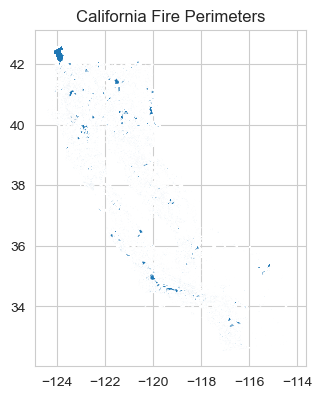

In [82]:
ca_fire_0_gdf.plot(figsize=(3.5, 5))
plt.title("California Fire Perimeters")
plt.show()

# Extract fires only happened inside the Los Angeles city boundary

In [83]:
def filter_fires_in_boundary(fire_gdf, boundary_gdf, mode="within"):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    boundary_union = boundary_gdf.geometry.union_all()
    
    if mode == "within":
        filtered_fires = fire_gdf[fire_gdf.geometry.within(boundary_union)]
    elif mode == "intersects":
        filtered_fires = fire_gdf[fire_gdf.geometry.intersects(boundary_union)]
    else:
        raise ValueError("mode must be 'within' or 'intersects'")
    
    return filtered_fires

def fix_invalid_geometries(gdf):
    # Attempt to fix invalid geometries using buffer(0)
    gdf['geometry'] = gdf.geometry.buffer(0)
    # Drop any that remain invalid (optional)
    gdf = gdf[gdf.is_valid]
    return gdf

def clip_fires_to_boundary(fire_gdf, boundary_gdf):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    fire_gdf = fix_invalid_geometries(fire_gdf)
    
    boundary_union = boundary_gdf.geometry.union_all()
    clipped_fires = gpd.clip(fire_gdf, boundary_union)
    return clipped_fires

<Axes: >

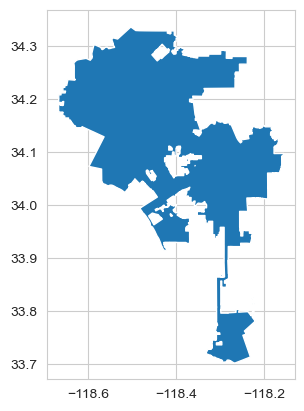

In [84]:
la_boundary = gpd.read_file('la_city_boundary.geojson')
la_boundary.plot()

In [85]:
# Filter out the fires around and inside the LA city boundary
la_fire_0_gdf = filter_fires_in_boundary(ca_fire_0_gdf, la_boundary, mode="intersects")
print_df_info(la_fire_0_gdf, "ca_fire_0_df")

# Clip the fires that are strictly inside the LA city
la_fire_0_gdf_clipped = clip_fires_to_boundary(ca_fire_0_gdf, la_boundary)
print_df_info(la_fire_0_gdf_clipped, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (458, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014. 2013. 2012. 2010.
 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2000. 1999. 1994. 1993. 1992.
 1991. 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979.
 1978. 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967.
 1966. 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955.
 1954. 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1944. 1943. 1942.
 1941. 1938. 1937. 1935. 1933. 1932. 1929. 1927. 1925. 1924. 1923. 1922.
 1921. 1919. 1918. 1916. 1915. 1914. 1913. 1911. 1910. 1878.]

--- Info for ca_fire_0_df ---
Dimensions: (458, 22)
Columns: ['OBJECTID', 

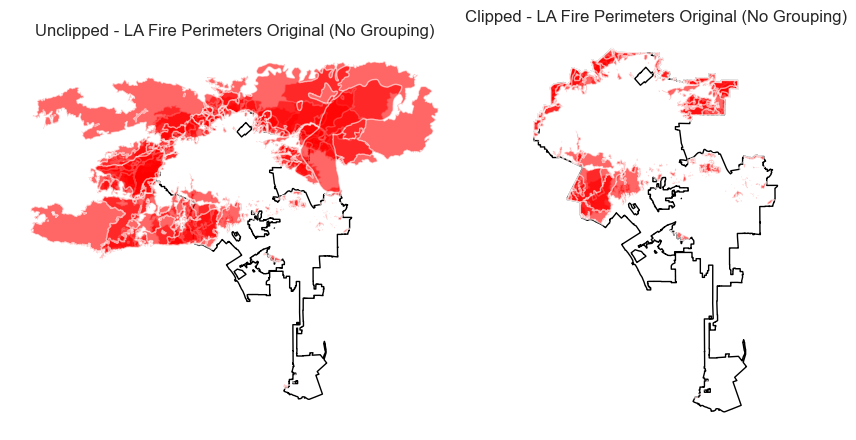

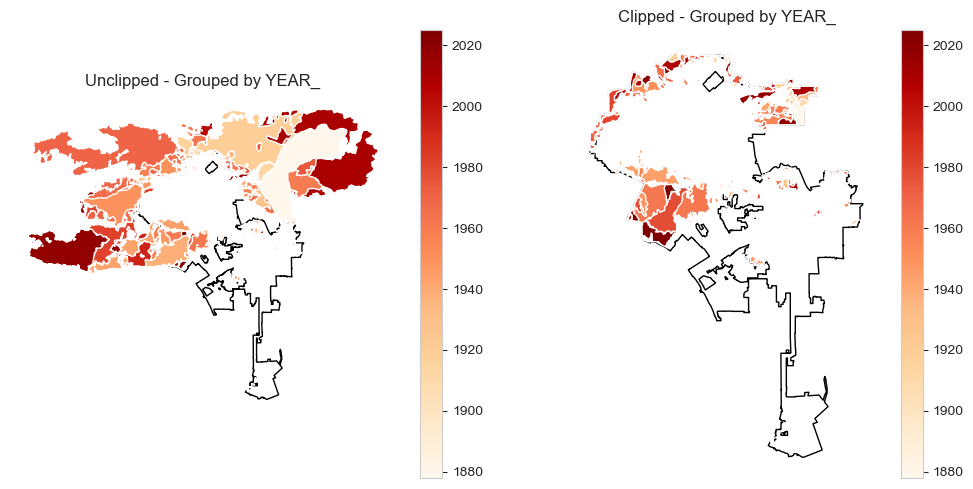

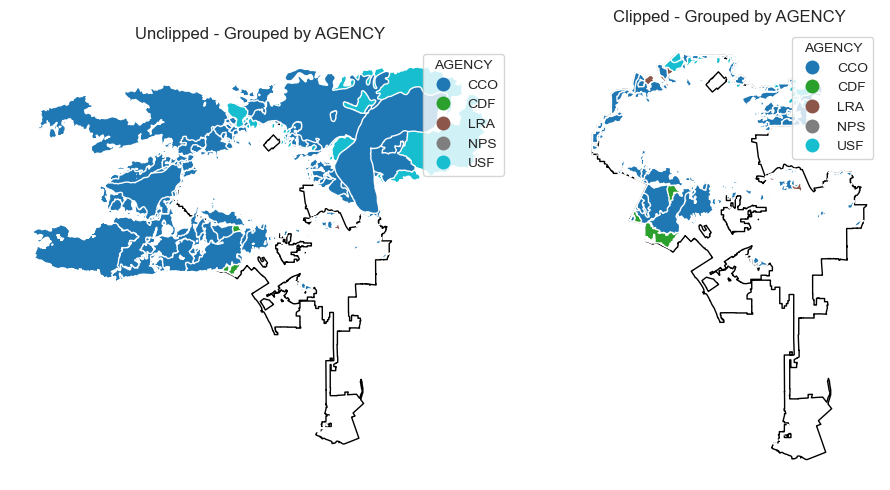

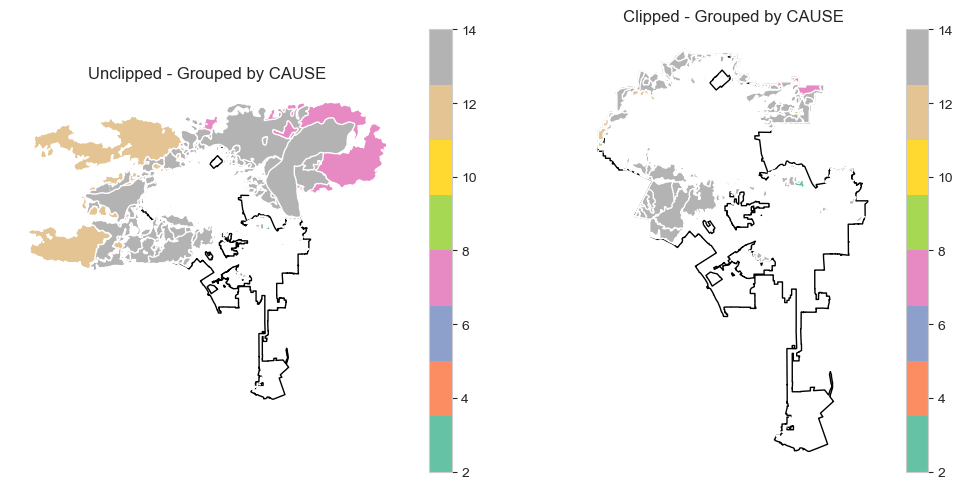

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

# Unclipped original
la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
la_fire_0_gdf.plot(ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Unclipped - LA Fire Perimeters Original (No Grouping)')
axes[0].axis('off')

# Clipped original
la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
la_fire_0_gdf_clipped.plot(ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Clipped - LA Fire Perimeters Original (No Grouping)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

group_cols = ['YEAR_', 'AGENCY', 'CAUSE']
colormaps = ['OrRd', 'tab10', 'Set2']

for group_col, cmap in zip(group_cols, colormaps):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    col_dtype = la_fire_0_gdf[group_col].dtype
    is_categorical = is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype)

    legend_args = {'legend': True}
    if is_categorical:
        legend_args['legend_kwds'] = {'title': group_col}

    # Unclipped plot
    la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
    la_fire_0_gdf.plot(
        ax=axes[0],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[0].set_title(f'Unclipped - Grouped by {group_col}')
    axes[0].axis('off')

    # Clipped plot
    la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
    la_fire_0_gdf_clipped.plot(
        ax=axes[1],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[1].set_title(f'Clipped - Grouped by {group_col}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Take a close look to the LA only data

In [87]:
print(la_fire_0_gdf)

       OBJECTID   YEAR_ STATE AGENCY UNIT_ID  FIRE_NAME   INC_NUM  \
0             1  2025.0    CA    CDF     LDF  PALISADES  00000738   
4             5  2025.0    CA    CDF     LDF      HURST  00003294   
1175       1177  2021.0    CA    LRA     LAC  PALISADES  00001448   
1518       1520  2021.0    CA    LRA     LDF       PEAK  00001026   
1972       1974  2020.0    CA    CCO     LAC    TOPANGA  00216968   
...         ...     ...   ...    ...     ...        ...       ...   
22265     22267  1913.0    CA    USF     ANF             00000000   
22428     22430  1911.0    CA    USF     ANF             00000000   
22607     22609  1910.0    CA    USF     ANF             00000000   
22638     22640  1910.0    CA    USF     ANF             00000000   
22732     22734  1878.0    CA    CCO     LAC             00000000   

         ALARM_DATE     CONT_DATE  CAUSE  ...     GIS_ACRES  \
0      1.736237e+12  1.738310e+12     14  ...  23448.880000   
4      1.736237e+12  1.736410e+12     14  ...

In [88]:
la_fire_0_gdf.shape

(458, 22)

In [89]:
la_fire_0_gdf_clipped.shape

(458, 22)

In [90]:
la_fire_0_gdf_clipped.to_csv("la_fire_0_gdf_clipped.csv", index=False)

In [91]:
df_trees = pd.read_csv("la_trees_combined.csv")

In [92]:
df_trees.shape

(848194, 5)

In [93]:
gdf_fire = la_fire_0_gdf_clipped.copy()

# Visualization Trees and Fires 

/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_38798/1006968694.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


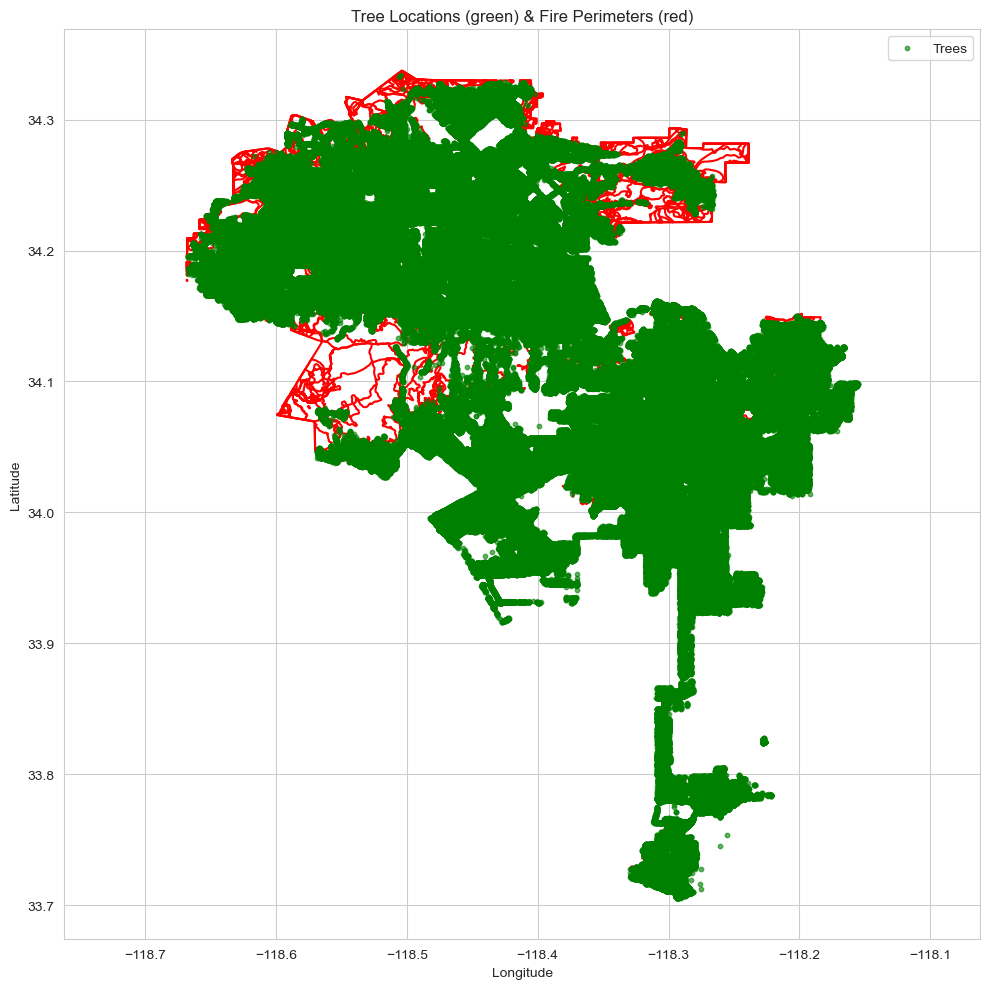

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt

# (Re-)create your GeoDataFrames if needed:
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Fire perimeters in red, no fill
gdf_fire.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=1.5,
    label="Fire Perimeters"
)

# Trees in green dots
gdf_trees.plot(
    ax=ax,
    marker="o",
    color="green",
    markersize=10,
    alpha=0.6,
    label="Trees"
)

# Legend and labels
ax.legend(loc="upper right")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Tree Locations (green) & Fire Perimeters (red)")
ax.axis("equal")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:465: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:467: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(title=self.legend_title)
/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_38798/2493478484.py:56: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Within Fire?")


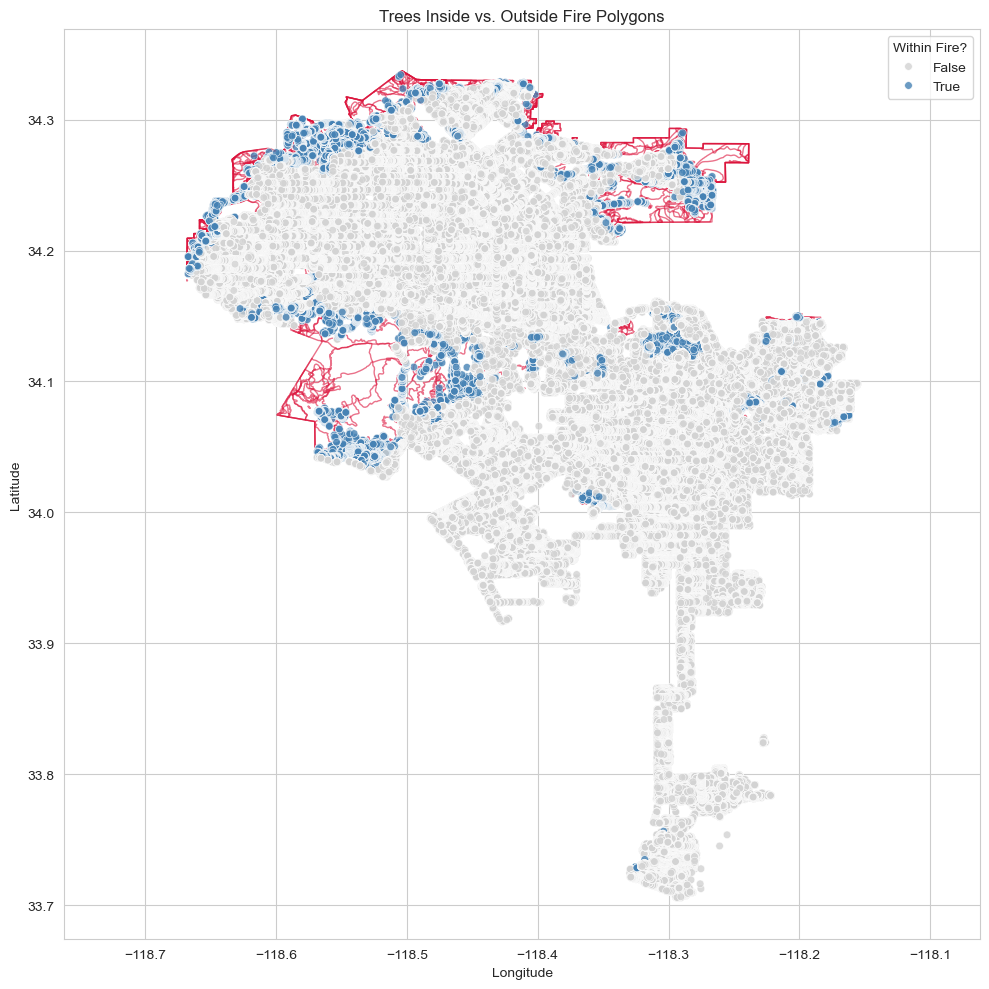

In [95]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# — 1. Build your GeoDataFrames (WGS84) —
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# — 2. Spatial‐join trees → fires (point within polygon) —
joined = gpd.sjoin(
    gdf_trees,
    gdf_fire[['geometry']],
    how="left",             # keep all trees
    predicate="within"      # tree point within fire polygon
)

# — 3. Find which tree‐indices had a match —
inside_idx = joined.loc[joined['index_right'].notna(), :].index.unique()

# — 4. Make a boolean column on the original trees —
gdf_trees['in_fire'] = gdf_trees.index.isin(inside_idx)

# — 5. Plot with Seaborn —
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))

# Fire perimeters underneath
gdf_fire.plot(
    ax=ax,
    facecolor="none",
    edgecolor="crimson",
    linewidth=1,
    alpha=0.6,
    label="Fire Perimeter"
)

# Trees: outside in gray, inside in blue
sns.scatterplot(
    data=gdf_trees,
    x="Longitude", y="Latitude",
    hue="in_fire",
    palette={False:"lightgray", True:"steelblue"},
    s=30, alpha=0.8,
    ax=ax,
    legend="brief"
)

ax.set_title("Trees Inside vs. Outside Fire Polygons")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.axis("equal")
plt.legend(title="Within Fire?")
plt.tight_layout()
plt.show()


# Function that can change the buffer

In [138]:
def trees_within_fire_buffer(df_trees, gdf_fire, buffer_meters):
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1. Convert to GeoDataFrame (WGS84)
    gdf_trees = gpd.GeoDataFrame(
        df_trees.copy(),
        geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
        crs="EPSG:4326"
    )

    gdf_fire = gdf_fire.to_crs("EPSG:4326")

    # 2. Project to a metric CRS for accurate buffering
    gdf_fire_proj = gdf_fire.to_crs(epsg=3310)
    gdf_trees_proj = gdf_trees.to_crs(epsg=3310)

    # 3. Buffer the fire polygons
    gdf_fire_proj['geometry'] = gdf_fire_proj.geometry.buffer(buffer_meters)

    # 4. Spatial join to find trees within buffer
    joined = gpd.sjoin(
        gdf_trees_proj,
        gdf_fire_proj[['geometry']],
        how="left",
        predicate="within"
    )

    # 5. Create boolean column
    inside_idx = joined.loc[joined['index_right'].notna(), :].index.unique()
    gdf_trees['in_fire_buffer'] = gdf_trees_proj.index.isin(inside_idx)

    # 6. Plot
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))

    gdf_fire_proj.to_crs(epsg=4326).plot(
        ax=ax,
        facecolor="none",
        edgecolor="crimson",
        linewidth=1,
        alpha=0.6,
        label=f"{buffer_meters}m Fire Buffer"
    )

    sns.scatterplot(
        data=gdf_trees,
        x="Longitude", y="Latitude",
        hue="in_fire_buffer",
        palette={False: "lightgray", True: "steelblue"},
        s=30, alpha=0.8,
        ax=ax,
        legend="brief"
    )

    ax.set_title(f"Trees Within {buffer_meters}m of Fire Perimeter")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis("equal")
    plt.legend(title="Within Buffer?")
    plt.tight_layout()
    plt.show()

    # 7. Summary statistics
    total_trees = len(gdf_trees)
    trees_in_buffer = gdf_trees['in_fire_buffer'].sum()
    percent = 100 * trees_in_buffer / total_trees
    print(f"{trees_in_buffer} out of {total_trees} trees ({percent:.2f}%) fall within a {buffer_meters}m fire buffer.")

    return gdf_trees[['Longitude', 'Latitude', 'in_fire_buffer']]


/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:465: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:467: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(title=self.legend_title)
/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_38798/793218945.py:61: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Within Buffer?")


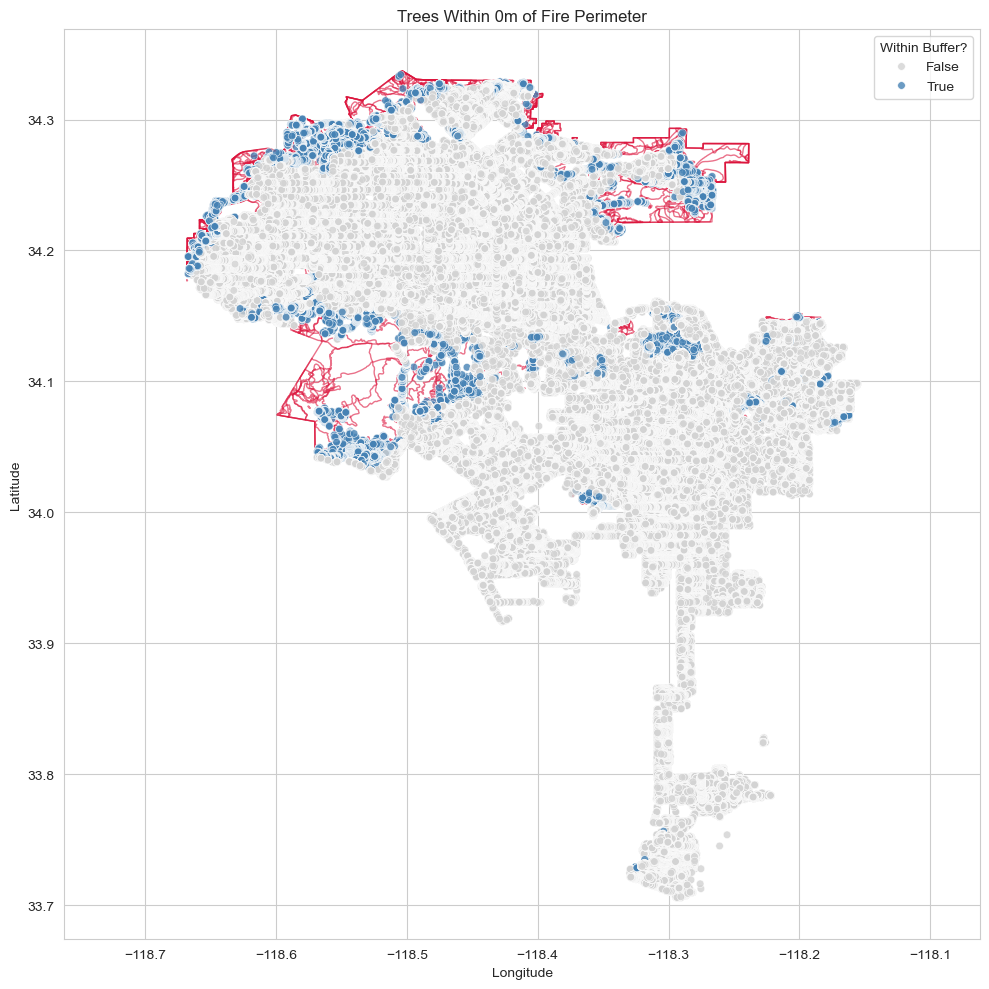

55013 out of 848194 trees (6.49%) fall within a 0m fire buffer.


,Longitude,Latitude,in_fire_buffer
0,-118.316354,34.057989,False
1,-118.316122,34.057987,False
2,-118.316252,34.057984,False
3,-118.316600,34.057924,False
4,-118.316591,34.057840,False
...,...,...,...
848189,-118.524730,34.281487,False
848190,-118.524696,34.281391,False
848191,-118.524487,34.281378,False
848192,-118.524269,34.281584,False


In [140]:
trees_within_fire_buffer(df_trees, gdf_fire, buffer_meters=0)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:465: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/relational.py:467: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(title=self.legend_title)
/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_38798/793218945.py:61: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Within Buffer?")


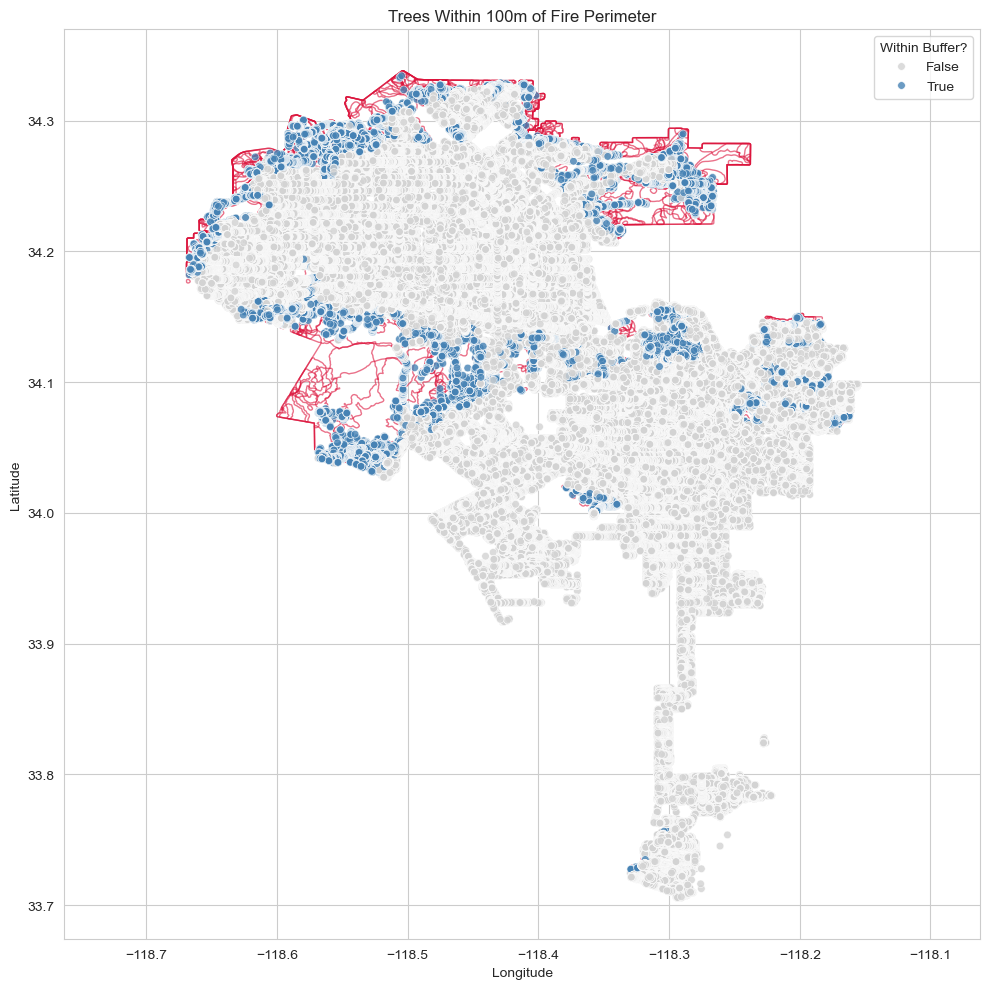

87526 out of 848194 trees (10.32%) fall within a 100m fire buffer.


,Longitude,Latitude,in_fire_buffer
0,-118.316354,34.057989,False
1,-118.316122,34.057987,False
2,-118.316252,34.057984,False
3,-118.316600,34.057924,False
4,-118.316591,34.057840,False
...,...,...,...
848189,-118.524730,34.281487,True
848190,-118.524696,34.281391,True
848191,-118.524487,34.281378,True
848192,-118.524269,34.281584,True


In [149]:
trees_within_fire_buffer(df_trees, gdf_fire, buffer_meters=100)

In [179]:
gdf_fire[["OBJECTID","GIS_ACRES", "YEAR_"]].drop_duplicates().sort_values(by='GIS_ACRES', ascending=False).head(20)

,OBJECTID,GIS_ACRES,YEAR_
5461,5463,160833.100,2009.0
14213,14215,115537.400,1970.0
2359,2361,89551.380,2018.0
21331,21333,70796.410,1919.0
22732,22734,59468.880,1878.0
13383,13385,51220.440,1975.0
11831,11833,43097.430,1982.0
0,1,23448.880,2025.0
6817,6819,23396.390,2005.0
14789,14791,23093.650,1967.0


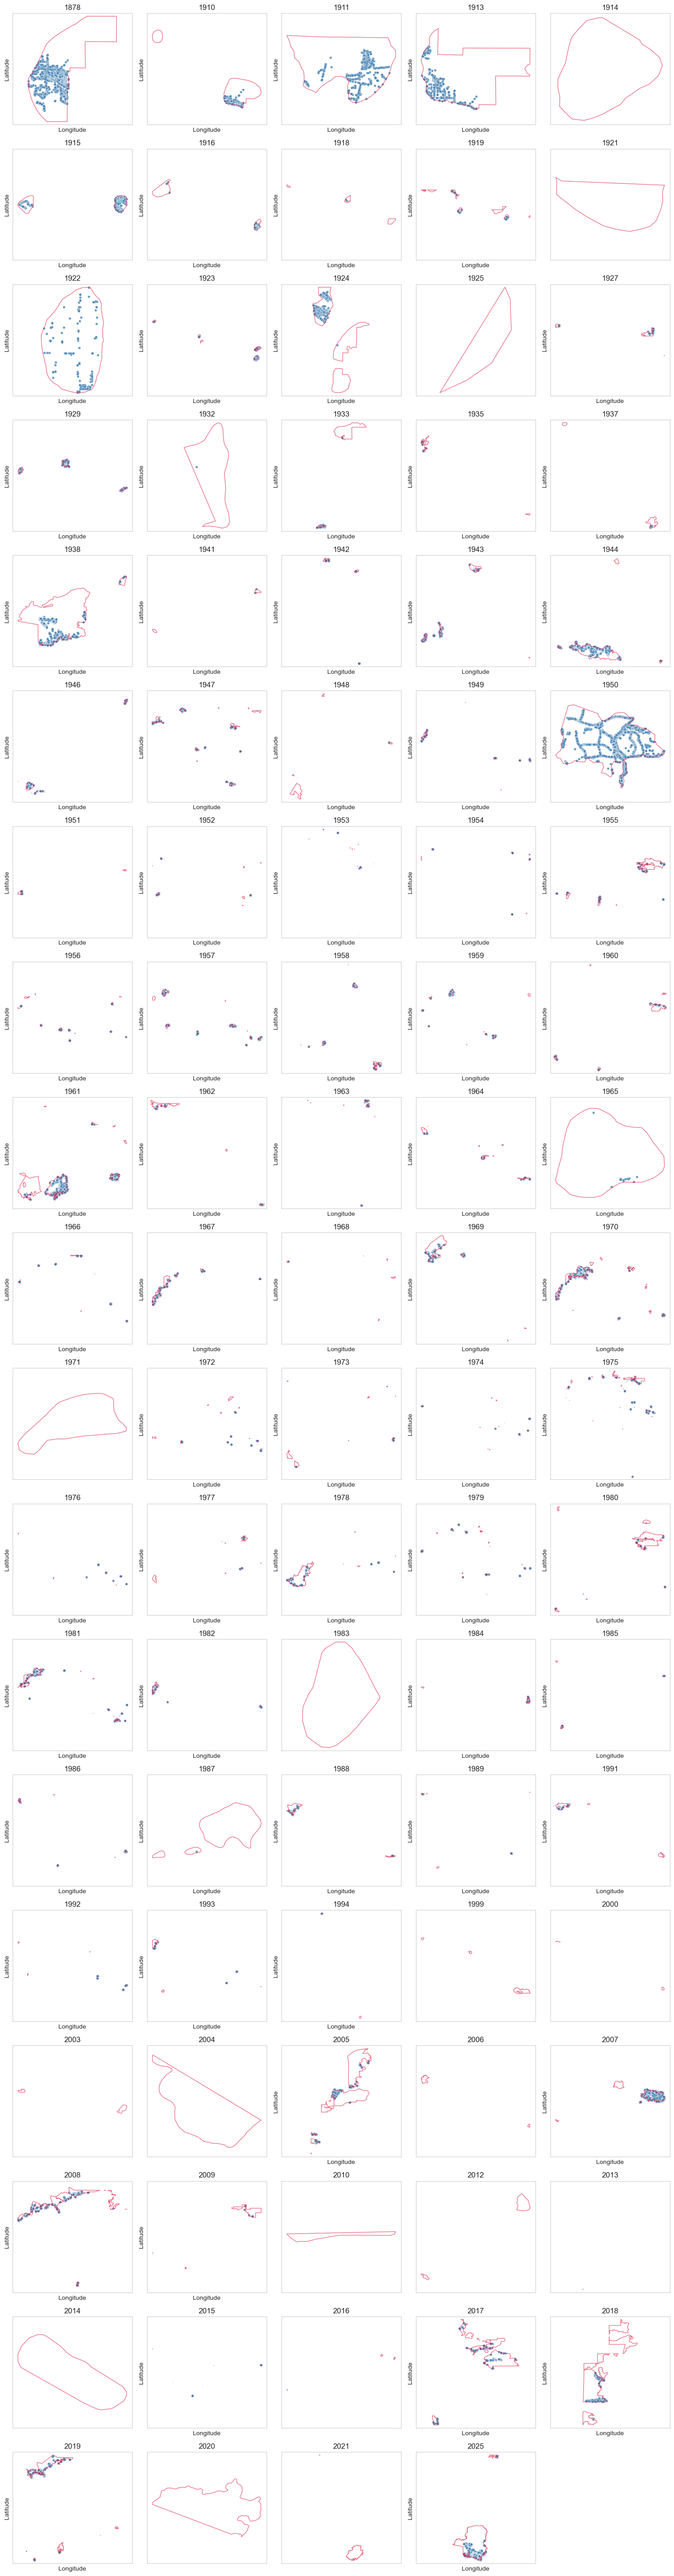

In [ ]:
import math
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# 2. Spatial‐join to tag each tree with the YEAR_ of the fire it falls in
joined = gpd.sjoin(
    gdf_trees,
    gdf_fire[['YEAR_','geometry']],
    how='inner',
    predicate='within'
)

# 3. Unique years present in your fire data
years = sorted(gdf_fire['YEAR_'].dropna().unique())

# 4. Setup subplot grid
n = len(years)
ncols = 5
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
axes = axes.flatten()

# 5. Loop over each year
sns.set_style("whitegrid")
for ax, year in zip(axes, years):
    # 5a. Plot that year's fire perimeters (just the boundaries)
    gdf_fire[gdf_fire['YEAR_']==year].boundary.plot(
        ax=ax,
        edgecolor='crimson',
        linewidth=1,
        alpha=0.6
    )
    
    # 5b. Find trees that joined to that year
    tree_idxs = joined[joined['YEAR_']==year].index
    subset = gdf_trees.loc[tree_idxs]
    
    # 5c. Plot those trees with seaborn
    sns.scatterplot(
        x=subset['Longitude'],
        y=subset['Latitude'],
        ax=ax,
        s=15,
        color='steelblue',
        alpha=0.8,
        legend=False
    )
    
    ax.set_title(f"{int(year)}")
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

# 6. Remove extra axes
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


# Merge Fire and Tree (92768 rows with 55013 unique trees)

In [150]:
# 1. Add a unique ID to each tree
df_trees['tree_id'] = range(len(df_trees))

# 2. Build the tree GeoDataFrame (now contains tree_id)
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)

# 3. Ensure fires have the same CRS
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# 4. Spatial-join: attach fire attributes to each tree within a fire
gdf_merged = gpd.sjoin(
    gdf_trees,
    gdf_fire,
    how="inner",
    predicate="within"
).reset_index(drop=True)

# Now gdf_merged has a column 'tree_id' you can use to trace back each original tree
gdf_merged

,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,1.0,624.3035,NaN,NaN,NaN,00000000,NaN,1950-1959,3.709861e+06,8002.545419
3,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),17346,17348,1950.0,...,1.0,4233.7710,NaN,NaN,NaN,00000000,NaN,1950-1959,2.516131e+07,31893.552189
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,1.0,80.7574,NaN,NaN,NaN,00000000,NaN,1960-1969,4.783674e+05,4025.625330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92763,34.281985,-118.524873,swamp mallee (Eucalyptus spathulata),1.0,False,848183,POINT (-118.52487 34.28199),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92764,34.281909,-118.524855,cork oak (Quercus suber),1.0,False,848184,POINT (-118.52486 34.28191),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92765,34.281829,-118.524832,cork oak (Quercus suber),1.0,False,848185,POINT (-118.52483 34.28183),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92766,34.281753,-118.524804,cork oak (Quercus suber),1.0,False,848186,POINT (-118.5248 34.28175),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800


In [151]:
gdf_merged.columns

Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
       'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
       'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE',
       'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME',
       'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area',
       'Shape__Length'],
      dtype='object')

In [152]:
len(gdf_merged["Species"].unique())

439

In [153]:
gdf_merged["Species"].value_counts()

Species
coast live oak (Quercus agrifolia)         24808
Canary Island pine (Pinus canariensis)      4969
California sycamore (Platanus racemosa)     4480
Aleppo pine (Pinus halepensis)              3989
eucalyptus species (Eucalyptus spp.)        3940
                                           ...  
Colorado juniper (Juniperus scopulorum)        1
eastern cottonwood (Populus deltoides)         1
Jelecote pine (Pinus patula)                   1
TEA TREE (Leptospermum scoparium)              1
pony-tail palm (Beaucarnea recurvata)          1
Name: count, Length: 439, dtype: int64

In [154]:
gdf_merged.to_csv("gdf_merged.csv", index=False)

In [155]:
len(gdf_merged["tree_id"].unique())

55013

In [156]:
gdf_merged["tree_id"].value_counts() #??? Feature Variable

tree_id
721894    7
721865    7
722081    7
722060    7
721927    7
         ..
617583    1
617584    1
617588    1
617589    1
848187    1
Name: count, Length: 55013, dtype: int64

In [106]:
gdf_merged['GIS_ACRES'].sort_values(ascending=False) # Target Variable

19168    160833.100000
8408     160833.100000
188      160833.100000
10179    160833.100000
187      160833.100000
             ...      
54661         0.634698
54649         0.634698
54636         0.634698
54623         0.634698
83030         0.350373
Name: GIS_ACRES, Length: 92768, dtype: float64

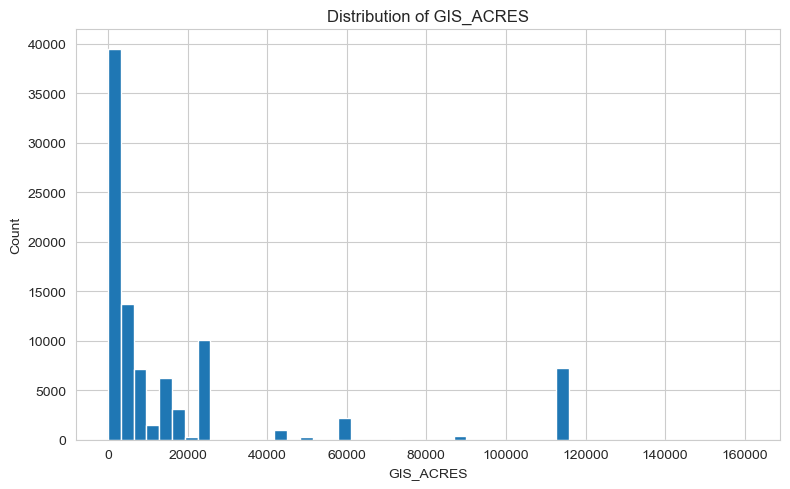

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
gdf_merged['GIS_ACRES'].hist(bins=50)
plt.xlabel('GIS_ACRES')
plt.ylabel('Count')
plt.title('Distribution of GIS_ACRES')
plt.tight_layout()
plt.show()

In [108]:
gdf_merged["YEAR_"].unique()

array([1944., 1959., 1950., 1960., 1961., 1955., 1947., 1970., 1981.,
       2008., 1943., 1952., 2025., 1927., 1878., 1942., 1924., 2019.,
       1956., 1958., 1929., 1975., 2009., 1954., 2017., 1938., 1967.,
       1976., 1913., 1922., 1916., 1982., 1911., 1946., 1923., 1979.,
       1985., 1972., 1957., 1969., 1915., 1980., 1964., 1935., 1966.,
       1949., 1919., 1984., 1978., 1986., 1910., 1951., 2005., 1993.,
       1991., 1962., 1932., 1988., 1994., 1953., 1941., 1937., 1973.,
       1992., 1918., 1963., 1933., 1974., 1948., 2018., 2007., 1977.,
       2015., 1989., 1965., 1968., 1987.])

In [157]:
gdf_merged["YEAR_"].value_counts()

YEAR_
1970.0    8192
2025.0    7681
1981.0    7183
1961.0    6213
2007.0    5536
          ... 
1994.0       2
1948.0       1
1932.0       1
1968.0       1
1987.0       1
Name: count, Length: 77, dtype: int64

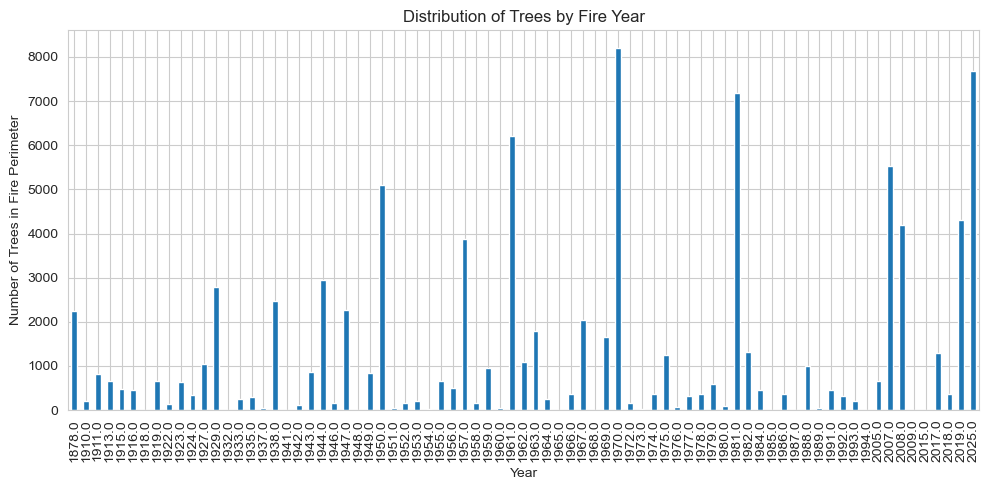

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
gdf_merged['YEAR_'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Trees in Fire Perimeter')
plt.title('Distribution of Trees by Fire Year')
plt.tight_layout()
plt.show()

In [110]:
gdf_merged.columns

Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
       'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
       'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE',
       'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME',
       'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area',
       'Shape__Length'],
      dtype='object')

In [111]:
gdf_merged["YEAR_"].value_counts()

YEAR_
1970.0    8192
2025.0    7681
1981.0    7183
1961.0    6213
2007.0    5536
          ... 
1994.0       2
1948.0       1
1932.0       1
1968.0       1
1987.0       1
Name: count, Length: 77, dtype: int64

In [112]:
gdf_merged['DECADES'].value_counts()

DECADES
1950-1959            32479
1960-1969            13484
1970-1979            11358
1980-1989            10426
2000-2009            10397
2020-January 2025     7681
2010-2019             5959
1990-1999              984
Name: count, dtype: int64

# Drop the duplicate trees remain to 55013 rows

In [113]:
# Keep only the first occurrence of each tree
fire_tree_unique = gdf_merged.drop_duplicates(subset='tree_id')

In [114]:
fire_tree_unique.shape

(55013, 29)

In [115]:
fire_tree_unique.head()

,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,1.0,624.3035,NaN,NaN,NaN,00000000,NaN,1950-1959,3.709861e+06,8002.545419
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,1.0,80.7574,NaN,NaN,NaN,00000000,NaN,1960-1969,4.783674e+05,4025.625330
5,34.089382,-118.452487,coast live oak (Quercus agrifolia),10.0,False,1826,POINT (-118.45249 34.08938),15424,15426,1961.0,...,1.0,6151.9790,NaN,NaN,NaN,00000000,NaN,1960-1969,3.640036e+07,48599.914373


# Next Step

1. Add new feature tree appeared times
2. Y(GIS_ACRES) categorized to Large Fire, Medium fire, Small Fire
3. Drop useless columns
4. Clean the Trees Speices within 20~50 kinds
5. Function to determine the range

# 1. Add New feature: tree appeared times

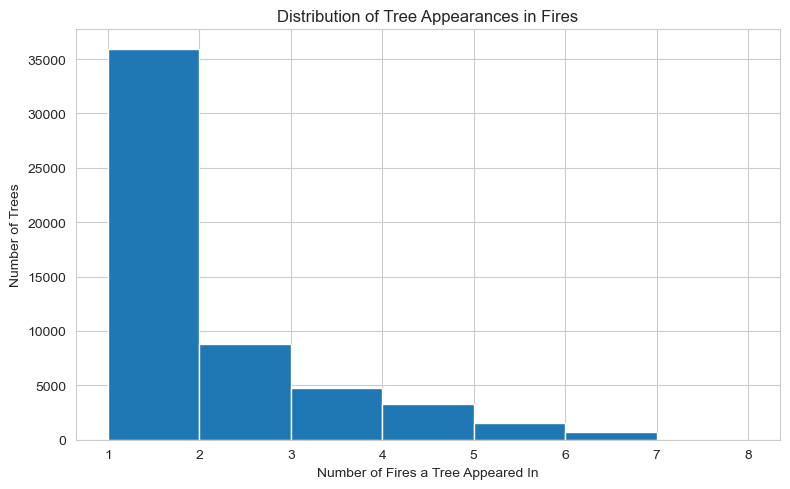

In [116]:
import matplotlib.pyplot as plt

tree_id_counts = gdf_merged["tree_id"].value_counts()

plt.figure(figsize=(8, 5))
tree_id_counts.hist(bins=range(1, tree_id_counts.max() + 2))
plt.xlabel('Number of Fires a Tree Appeared In')
plt.ylabel('Number of Trees')
plt.title('Distribution of Tree Appearances in Fires')
plt.tight_layout()
plt.show()

In [117]:
tree_counts = gdf_merged["tree_id"].value_counts()
fire_tree_unique["tree_appear_count"] = fire_tree_unique["tree_id"].map(tree_counts)
fire_tree_unique.head()

/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,tree_appear_count
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924,1
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924,1
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,624.3035,NaN,NaN,NaN,00000000,NaN,1950-1959,3.709861e+06,8002.545419,2
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,80.7574,NaN,NaN,NaN,00000000,NaN,1960-1969,4.783674e+05,4025.625330,1
5,34.089382,-118.452487,coast live oak (Quercus agrifolia),10.0,False,1826,POINT (-118.45249 34.08938),15424,15426,1961.0,...,6151.9790,NaN,NaN,NaN,00000000,NaN,1960-1969,3.640036e+07,48599.914373,1


In [162]:
fire_tree_unique[["OBJECTID", "GIS_ACRES"]]

,OBJECTID,GIS_ACRES
0,18164,4548.5230
1,18164,4548.5230
2,15798,624.3035
4,15674,80.7574
5,15426,6151.9790
...,...,...
92763,17827,416.0731
92764,17827,416.0731
92765,17827,416.0731
92766,17827,416.0731


In [180]:
fire_summary = fire_tree_unique[['OBJECTID', 'GIS_ACRES']].drop_duplicates().sort_values(by='GIS_ACRES', ascending=False)
fire_summary = fire_summary.reset_index(drop=True)

In [181]:
fire_summary

,OBJECTID,GIS_ACRES
0,5463,160833.100000
1,14215,115537.400000
2,21333,70796.410000
3,22734,59468.880000
4,13385,51220.440000
...,...,...
198,4022,1.193676
199,14104,1.134497
200,13382,1.087449
201,13084,0.634698


# 2. Categorized GIS_ACRES: A, B, C, D, E, F, G, H

In [118]:
fire_tree_unique["GIS_ACRES"]

0        4548.5230
1        4548.5230
2         624.3035
4          80.7574
5        6151.9790
           ...    
92763     416.0731
92764     416.0731
92765     416.0731
92766     416.0731
92767     416.0731
Name: GIS_ACRES, Length: 55013, dtype: float64

In [119]:
def categorize_fire_size(acres):
    if acres < 100:
        return 'Small Fire'
    elif acres < 5000:
        return 'Medium Fire'
    else:
        return 'Large Fire'

# Apply the function to create a new column
fire_tree_unique['FIRE_SIZE_CATEGORY'] = fire_tree_unique['GIS_ACRES'].apply(categorize_fire_size)

print(fire_tree_unique['FIRE_SIZE_CATEGORY'].value_counts())


FIRE_SIZE_CATEGORY
Medium Fire    28640
Large Fire     21659
Small Fire      4714
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# 3. Drop the Useless Columns

In [120]:
# Output the number of NA values for each column in ca_fire_0_df
na_counts = fire_tree_unique.isna().sum()
na_nonzero = na_counts[na_counts != 0]
print(na_nonzero)

INC_NUM             7
ALARM_DATE       2702
CONT_DATE       47306
C_METHOD        41511
OBJECTIVE         389
COMMENTS        45772
COMPLEX_NAME    55013
IRWINID         48742
FIRE_NUM         8129
COMPLEX_ID      55013
dtype: int64


In [121]:
fire_tree_unique.columns, fire_tree_unique.shape, fire_tree_unique.dtypes

(Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
        'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
        'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE',
        'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME',
        'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area',
        'Shape__Length', 'tree_appear_count', 'FIRE_SIZE_CATEGORY'],
       dtype='object'),
 (55013, 31),
 Latitude               float64
 Longitude              float64
 Species                 object
 DBH                    float64
 Any_Protected             bool
 tree_id                  int64
 geometry              geometry
 index_right              int64
 OBJECTID                 int64
 YEAR_                  float64
 STATE                   object
 AGENCY                  object
 UNIT_ID                 object
 FIRE_NAME               object
 INC_NUM                 object
 ALARM_DATE             float64
 CO

In [122]:
fire_tree_unique["UNIT_ID"].value_counts()

UNIT_ID
LAC    42985
LDF     6346
ANF     3216
VNC     2459
SMP        7
Name: count, dtype: int64

In [123]:
fire_tree_unique["FIRE_NAME"].value_counts()

FIRE_NAME
                       18529
GRIFFITH PARK           5792
PALISADES               5426
CLAMPITT                4909
WOODLAND HILLS #47      2853
                       ...  
MCELLVENEY                 1
CANOGA                     1
UNIVERSAL CITY #198        1
MAREK                      1
ENGINE 75-5                1
Name: count, Length: 77, dtype: int64

In [124]:
cols_to_drop = ['INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'OBJECTIVE', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', "FIRE_NUM", "COMPLEX_ID"]

In [125]:
fire_tree_unique = fire_tree_unique.drop(columns=cols_to_drop)
fire_tree_unique.columns

Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
       'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
       'UNIT_ID', 'FIRE_NAME', 'CAUSE', 'GIS_ACRES', 'DECADES', 'Shape__Area',
       'Shape__Length', 'tree_appear_count', 'FIRE_SIZE_CATEGORY'],
      dtype='object')

In [ ]:
fire_tree_unique.head()

,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,AGENCY,UNIT_ID,FIRE_NAME,CAUSE,GIS_ACRES,DECADES,Shape__Area,Shape__Length,tree_appear_count,FIRE_SIZE_CATEGORY
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,CCO,LAC,WOODLAND HILLS #47,14,4548.5230,1950-1959,2.694018e+07,35271.399924,1,Medium Fire
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,CCO,LAC,WOODLAND HILLS #47,14,4548.5230,1950-1959,2.694018e+07,35271.399924,1,Medium Fire
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,CCO,LAC,,14,624.3035,1950-1959,3.709861e+06,8002.545419,2,Medium Fire
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,CCO,LAC,,14,80.7574,1960-1969,4.783674e+05,4025.625330,1,Small Fire
5,34.089382,-118.452487,coast live oak (Quercus agrifolia),10.0,False,1826,POINT (-118.45249 34.08938),15424,15426,1961.0,...,CCO,LAC,BEL AIR,14,6151.9790,1960-1969,3.640036e+07,48599.914373,1,Large Fire


In [146]:
fire_tree_unique.shape

(55013, 21)

In [160]:
fire_tree_unique.to_csv("fire_tree_unique.csv", index=False)